# Lab session 8

### What is A2C?

Since the beginning of this course, we’ve studied two different reinforcement learning methods:

* **Value based methods** (Q-learning, Deep Q-learning): where we learn a value function that will map each state action pair to a value.
* **Policy based methods** (REINFORCE with Policy Gradients): where we directly optimize the policy without using a value function.

But both of these methods have big drawbacks. That’s why, today, we’ll study a new type of Reinforcement Learning method which we can call a “hybrid method”: Actor Critic. We’ll using two neural networks:

* **Actor**: Controls how our agent behaves (policy-based)
* **Critic**:  Measures how good the state is (value-based)

The Actor Critic model is a better score function. Instead of waiting until the end of the episode as we do in Monte Carlo REINFORCE, we make an update at each step (TD Learning).


At the beginning, you don’t know how to play, so you try some action randomly. The Critic observes your action and provides feedback.
Learning from this feedback, you’ll update your policy and be better at playing that game.

On the other hand, your friend (Critic) will also update their own way to provide feedback so it can be better next time.
As we can see, the idea of Actor Critic is to have two function approximator, the policy (actor) and the value function (critic). We estimate both with neural networks.

Because we have two models (Actor and Critic) that must be trained, it means that we have two set of weights that must be optimized separately.

### Submitting the code and experiment runs
In order to turn in your code and report, create 3 folders that contains
the following:
* Cartpole
    * A2C and PPO code using cartpole.
    * Plots 
* LunarLander
    * A2C and PPO code using LunarLander-v2 env
    * Plots
* Report
    * Report

A scientific report explaining
 * Difference between A2C and PPO?
 * Try solving LunarLander-v2 env. using already implemented code for cartpole Set N_TRIALS = 1 and REWARD_THRESHOLD = 100. You are only allowed to change MAX_EPISODES.
 * Compare the performance of A2C and PPO in different envs
 * If any difference please explain why?
 * What can be potential improvements?


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.distributions as distributions

import matplotlib.pyplot as plt
import numpy as np
import gym
from IPython.display import clear_output

#### Declare env

In [ ]:
env_id = 'CartPole-v1'

In [22]:
train_env = gym.make(env_id)
eval_env = gym.make(env_id)

In [24]:
SEED = 1234
train_env.seed(SEED);
eval_env.seed(int(SEED/2))
np.random.seed(SEED);
torch.manual_seed(SEED);

In [25]:
class BaseModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout = 0.5):
        """
        This is a basic Artificial Neural Network that can be used for both the Actor and the Critic.
        Parameters
        ----------
        input_dim: int
        
        hidden_dim: int
        
        output_dim: int
        
        dropout: float
        
        Returns
        -------
        """
        super().__init__()

        self.fc_1 = nn.Linear(input_dim, hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        """
        Prediction of the Neural Network given an input x (in RL, x is a state).
        The Network uses a dropout layer (to help generalize), and the ReLU activation function.
        Parameters
        ----------
        x: tensor
            input, i.e. state
        
        Returns
        -------
        x: tensor
            the network's prediction (output) for this input.
        """
        # TODO: write forward pass for NN
        # Hint: it should have layers, dropout, relu.

        return x

In [7]:
class ActorCritic(nn.Module):
    def __init__(self, actor, critic):
        """
        This is a joint model, with two ANNs within.
        Parameters
        ----------
        actor: BaseModel instance
        
        critic: BaseModel instance
        """
        super().__init__()
        
        self.actor = actor
        self.critic = critic
        
    def forward(self, state):
        """ 
        The output of the ActorCritic model is the concatenation of the actor and critic's outputs.
        Since the actor is a policy, we convert the output into probabilities using a softmax function.
        Parameters
        ----------
        state: tensor
            model input, i.e. state the agent is in
        
        Returns
        -------
        action_pred, value_pred: tensor, tensor
            the network's prediction (output) for this input.
        """

        action_pred = self.actor(state)
        value_pred = self.critic(state)
        
        # TODO: convert actions to probabilities using softmax
        action_pred = 
        
        return action_pred, value_pred

### Note: Reinitialise agent again if you change any hyperparameter. Don't retrain same agent.

In [8]:

INPUT_DIM = train_env.observation_space.shape[0]
HIDDEN_DIM = 128

# TODO: What should be the output dimention for actor and critic.
# HINT: actor controls policy and critic outputs only values
OUTPUT_DIM_ACTOR = 
OUTPUT_DIM_CRITIC = 
actor = BaseModel(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM_ACTOR)
critic = BaseModel(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM_CRITIC)

agent = ActorCritic(actor, critic)

In [9]:
def init_weights(m):
    """ Initializes the ANNs weights with a relevant distribution. """
    if type(m) == nn.Linear:
        torch.nn.init.xavier_normal_(m.weight)
        m.bias.data.fill_(0)

In [ ]:
agent.apply(init_weights)

In [11]:
LEARNING_RATE = 0.01

optimizer = optim.Adam(agent.parameters(), lr = LEARNING_RATE)

In [12]:
def train(env, agent, optimizer, discount_factor):
    """
    Performs a single training step over an episode.

    Parameters
    ----------
    agent: ActorCritic
    
    optimizer: PyTorch optimizer
    
    discount_factor: float
        discount gamma
    
    Returns
    -------
    policy_loss: float 
        loss of the policy (actor)
    
    value_loss: float
        loss of the value function approximator (critic)
    
    episode_reward: float
        reward for this episode
    """
    agent.train()
    
    log_prob_actions = []
    values = []
    rewards = []
    done = False
    episode_reward = 0

    state = env.reset()

    while not done:

        state = torch.FloatTensor(state).unsqueeze(0)
        
        # TODO: get action
        action_prob = 
        # TODO: get value
        value_pred = 
         
        dist = distributions.Categorical(action_prob)

        action = dist.sample()
        
        log_prob_action = dist.log_prob(action)
        
        if env_id == 'Pendulum-v0':
            state, reward, done, _ = env.step(action)
        else:
            state, reward, done, _ = env.step(action.item())

        log_prob_actions.append(log_prob_action)
        values.append(value_pred)
        rewards.append(reward)

        episode_reward += reward
    
    log_prob_actions = torch.cat(log_prob_actions)
    values = torch.cat(values).squeeze(-1)
    
    returns = calculate_returns(rewards, discount_factor)
    advantages = calculate_advantages(returns, values)
    
    policy_loss, value_loss = update_policy(advantages, log_prob_actions, returns, values)

    optimizer.zero_grad()
    
    policy_loss.backward()
    value_loss.backward()
    
    optimizer.step()

    return policy_loss.item(), value_loss.item(), episode_reward

In [13]:
def calculate_returns(rewards, discount_factor, normalize = True):
    """
    Function to calculate rewards in time step order and normalize them.
    Normalizing stabilizes the results.
    Parameters
    ----------
    rewards: list of floats
    
    discount_factor: float
    
    Returns
    -------
    returns: tensor
        tensor of returns G_t in time-step order
    """
    # TODO: calculate future rewards
    
    
    if normalize:
        
        returns = (returns - returns.mean()) / returns.std()
        
    return returns

In [27]:
def calculate_advantages(returns, values, normalize = True):
    """
    Computes the advantage for all actions. 
    Reminder: the Advantage function for an action a is A(s,a) = Q(s,a) - V(s)
    Normalizing stabilizes the results.
    Parameters
    ----------
    returns: tensor
        Returns G_t during an episode
    
    values: tensor
        Value estimates V(s_t)
    
    Returns
    -------
    advantages: tensor
    """
    # TODO: calculate advantage
    advantages = 
    
    # TODO: write code to normalize the values
  
        
    return advantages

In [15]:
def update_policy(advantages, log_prob_actions, returns, values):
    """
    Function to update your policy based on your actor and critic loss.
    
    Parameters
    ----------
    advantages: tensor
    
    log_prob_actions: tensor
    
    returns: tensor
    
    values: tensor
    
    optimizer: adam instance
    
    Returns
    -------

    """
    
    advantages = advantages.detach()
    returns = returns.detach()
    
    # TODO: calculate policy loss based on advantages and log_prob_actions.
    policy_loss = 
    
    # TODO: calculate value loss based on Mean Absolute Error
    value_loss = 
        
    
    return policy_loss, value_loss

In [16]:
def evaluate(env, agent, vis=False):
    """
    Function to evaluate your agent's performance.
    """
    agent.eval()
    
    rewards = []
    done = False
    episode_reward = 0

    state = env.reset()
    if vis: env.render()
    while not done:

        state = torch.FloatTensor(state).unsqueeze(0)

        with torch.no_grad():
        
            action_prob, _ = agent(state)
                
        action = torch.argmax(action_prob, dim = -1)
                
        if env_id == 'Pendulum-v0':
            state, reward, done, _ = env.step(action)
        else:
            state, reward, done, _ = env.step(action.item())

        episode_reward += reward
        
    return episode_reward

In [17]:
def plot(frame_idx, train_rewards, policy_loss, value_loss):
    """
    Plots the running reward and losses.
    Parameters
    ----------
    frame_idx: int
        frame id
    rewards: int
        accumulated reward
    losses: int
        loss
    """
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, np.mean(train_rewards[-10:])))
    plt.plot(train_rewards)
    plt.subplot(132)
    plt.title('policy loss')
    plt.plot(policy_loss)
    plt.subplot(133)
    plt.title('value loss')
    plt.plot(value_loss)
    plt.show()

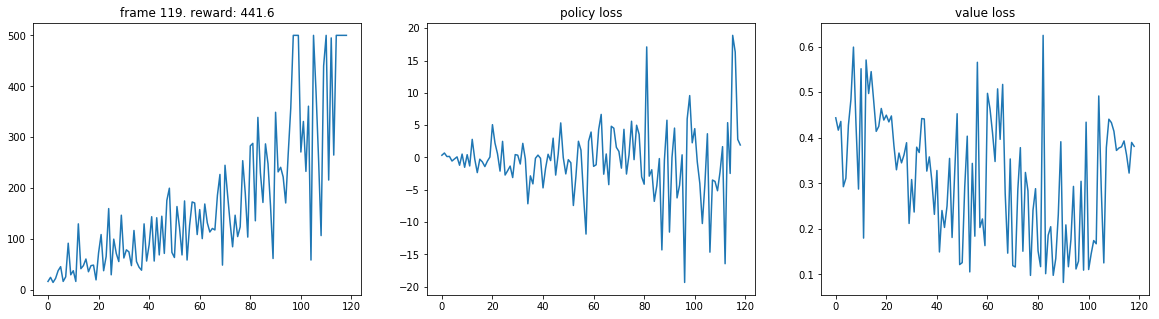

Reached reward threshold in 119 episodes


In [18]:
MAX_EPISODES = 500
DISCOUNT_FACTOR = 0.99
N_TRIALS = 25
REWARD_THRESHOLD = 475

policy_losses = []
value_losses = []
train_rewards = []
test_rewards = []

for episode in range(1, MAX_EPISODES+1):
    
    policy_loss, value_loss, train_reward = train(train_env, agent, optimizer, DISCOUNT_FACTOR)
    test_reward = evaluate(eval_env, agent, False)
    
    train_rewards.append(train_reward)
    test_rewards.append(test_reward)
    policy_losses.append(policy_loss)
    value_losses.append(value_loss)
    
    mean_train_rewards = np.mean(train_rewards[-N_TRIALS:])
    mean_test_rewards = np.mean(test_rewards[-N_TRIALS:])
    
    plot(episode, train_rewards, policy_losses, value_losses)

    if mean_test_rewards >= REWARD_THRESHOLD:
        
        print(f'Reached reward threshold in {episode} episodes')
        
        break

In [19]:
def plot_evaluate():
    plt.figure(figsize=(12,8))
    plt.plot(test_rewards, label='Test Reward')
    plt.plot(train_rewards, label='Train Reward')
    plt.xlabel('Episode', fontsize=20)
    plt.ylabel('Reward', fontsize=20)
    plt.hlines(REWARD_THRESHOLD, 0, len(test_rewards), color='r')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

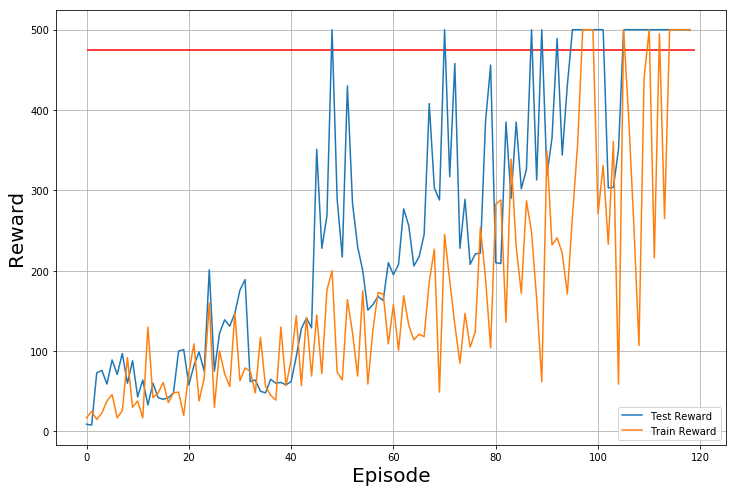

In [20]:
plot_evaluate()

## PPO

The RL algorithms have many moving parts that are hard to debug, and they require substantial effort in tuning in order to get good results.
PPO strikes a balance between ease of implementation, sample complexity, and ease of tuning, trying to compute an update at each step that minimizes the cost function while ensuring the deviation from the previous policy is relatively small.
The central idea for Proximal Policy Optimization is to avoid having too large policy update

PPO uses an adaptive KL penalty to control the change of the policy at each iteration. It uses an objective function not typically found in other algorithms.

Here we implement PPO agent in A2C style. Which means it follows same actor critic implementation. 

#### Reinitialise your agents
##### TODO: Reuse A2C methods to validate if PPO is running correctly with cartpole-env.

In [ ]:
agent = ActorCritic(actor, critic)
agent.apply(init_weights)
optimizer = optim.Adam(agent.parameters(), lr = LEARNING_RATE)

In [26]:
def update_policy_ppo(agent, states, actions, log_prob_actions, advantages, returns, optimizer, ppo_steps, ppo_clip):
    
    total_policy_loss = 0 
    total_value_loss = 0
    
    advantages = advantages.detach()
    log_prob_actions = log_prob_actions.detach()
    actions = actions.detach()
    
    for _ in range(ppo_steps):
                
        #get new log prob of actions for all input states
        action_prob, value_pred = agent(states)
        value_pred = value_pred.squeeze(-1)
        dist = distributions.Categorical(action_prob)
        
        #new log prob using old actions
        new_log_prob_actions = dist.log_prob(actions)
        
        policy_ratio = (new_log_prob_actions - log_prob_actions).exp()
                
        policy_loss_1 = policy_ratio * advantages
        policy_loss_2 = torch.clamp(policy_ratio, min = 1.0 - ppo_clip, max = 1.0 + ppo_clip) * advantages
        
        policy_loss = - torch.min(policy_loss_1, policy_loss_2).sum()
        
        value_loss = F.smooth_l1_loss(returns, value_pred).sum()
    
        optimizer.zero_grad()

        policy_loss.backward()
        value_loss.backward()

        optimizer.step()
    
        total_policy_loss += policy_loss.item()
        total_value_loss += value_loss.item()
    
    return total_policy_loss / ppo_steps, total_value_loss / ppo_steps

In [ ]:
def train_ppo(env, agent, optimizer, discount_factor, ppo_steps, ppo_clip):
        
    agent.train()
        
    states = []
    actions = []
    log_prob_actions = []
    values = []
    rewards = []
    done = False
    episode_reward = 0

    state = env.reset()

    while not done:

        state = torch.FloatTensor(state).unsqueeze(0)

        #append state here, not after we get the next state from env.step()
        states.append(state)
        
        action_prob, value_pred = agent(state)
                
        dist = distributions.Categorical(action_prob)
        
        action = dist.sample()
        
        log_prob_action = dist.log_prob(action)
        
        if env_id == 'Pendulum-v0':
            state, reward, done, _ = env.step(action)
        else:
            state, reward, done, _ = env.step(action.item())

        actions.append(action)
        log_prob_actions.append(log_prob_action)
        values.append(value_pred)
        rewards.append(reward)
        
        episode_reward += reward
    
    states = torch.cat(states)
    actions = torch.cat(actions)    
    log_prob_actions = torch.cat(log_prob_actions)
    values = torch.cat(values).squeeze(-1)
    
    returns = calculate_returns(rewards, discount_factor)
    advantages = calculate_advantages(returns, values)
    
    policy_loss, value_loss = update_policy_ppo(agent, states, actions, log_prob_actions, advantages, returns, optimizer, ppo_steps, ppo_clip)

    return policy_loss, value_loss, episode_reward

In [ ]:
MAX_EPISODES = 500
DISCOUNT_FACTOR = 0.99
N_TRIALS = 25
REWARD_THRESHOLD = 475
PPO_STEPS = 5
PPO_CLIP = 0.2

policy_losses = []
value_losses = []
train_rewards = []
test_rewards = []

for episode in range(1, MAX_EPISODES+1):
    
    policy_loss, value_loss, train_reward = train_ppo(train_env, agent, optimizer, DISCOUNT_FACTOR, PPO_STEPS, PPO_CLIP)
    
    test_reward = evaluate(eval_env, agent)
    
    train_rewards.append(train_reward)
    test_rewards.append(test_reward)
    policy_losses.append(policy_loss)
    value_losses.append(value_loss)

    
    mean_train_rewards = np.mean(train_rewards[-N_TRIALS:])
    mean_test_rewards = np.mean(test_rewards[-N_TRIALS:])
    
    plot(episode, train_rewards, policy_losses, value_losses)
    
    if mean_test_rewards >= REWARD_THRESHOLD:
        
        print(f'Reached reward threshold in {episode} episodes')
        
        break